# CoSpar basics

Below, we walk you through typical steps of analysis. We use the subsampled hematopoiesis dataset (Wang et al., 2021; adapted from Weinreb et al., 2020) so that this tutorial can be run in ~ 8 minutes.
For further demonstration, please see notebooks in the **Examples** section. 

**Contents**:
    
* Initialization

* Preprocessing and dimension reduction (optional)

* Basic clonal analysis

* Transition map inference

* Save or load pre-computed data (optional)

* Plotting

* Miscellaneous

In [1]:
import sys
import os
#new_path=os.getcwd()+"/CoSpar/"
new_path='/Users/shouwenwang/Patch Bio Dropbox/Shouwen Wang/Python/CoSpar'
sys.path.append(new_path)

import cospar as cs

In [2]:
cs.logging.print_version()

# Set the messaging level. At a given value, a running function will 
# print information at or below its level.  
cs.settings.verbosity=2 #range: 0 (error),1 (warning),2 (info),3 (hint). 

# Plot setting. If you want to control a particular plot, 
# just change the setting here, and run that plotting function.
cs.settings.set_figure_params(format='png',figsize=[4,3.5],dpi=75,fontsize=14,pointsize=3) 

Running cospar 0.1.8 (python 3.6.12) on 2021-07-11 16:14.


Each dataset should have its folder to avoid conflicts.  

In [3]:
# set the directory for figures and data. If not existed yet, they will be created automtaically.
cs.settings.data_path='data_cospar' 
cs.settings.figure_path='fig_cospar' 
cs.hf.set_up_folders()

## Initialization

The first step is to construct an ``anndata`` object that stores all relevant data. The key annotations after initialization are:

* **adata.X**: state count matrix, shape (n_cell, n_gene). **This should not be log-normalized.**

* **adata.var_names**: list of gene names, shape (n_genes,)

* **adata.obs['time_info']**: time annotation (type: `str`) for each cell, shape (n_cell,)

* **adata.obs['state_info']**: state annotation for each cell, shape (n_cell, 1)
        
* **adata.obsm['X_clone']**: clonal labels for each cell in the form of np.array or sparse matrix, shape (n_cell, n_clone)
    
* **adata.obsm['X_pca']**: PCA matrix, shape (n_cell, n_pcs)

* **adata.obsm['X_emb']**: two-dimensional embedding, shape (n_cell, 2)

`cs.pp.initialize_adata_object` assists this initialization. We provide a tutorial for this step by loading a preprocessed dataset, extracting each component, and then re-assembling them using our initialization function. 

Load an existing dataset. (If you have pre-processed data, you can load it with `cs.hf.read(file_name)`.)

In [4]:
adata_orig_0=cs.datasets.hematopoiesis_subsampled()

Extract each component.

In [5]:
# This is just a name to indicate this data for saving results. Can be arbitrary but should be unique to this data.
data_des='blood' 

X_state=adata_orig_0.X # np.array or sparse matrix, shape (n_cell, n_gene)
gene_names=adata_orig_0.var_names # List of gene names, shape (n_genes,)     
    
# Clonal data matrix, np.array or sparse matrix, shape: (n_cell, n_clone)
X_clone=adata_orig_0.obsm['X_clone'] 

# 2-d embedding, np.array, shape: (n_cell, 2)
X_emb=adata_orig_0.obsm['X_emb'] 

# A vector of cluster id for each cell, np.array, shape: (n_cell,),
state_info=adata_orig_0.obs['state_info'] 

# principle component matrix, np.array, shape: (n_cell, n_pcs)
X_pca=adata_orig_0.obsm['X_pca'] 

# A vector of time info, np.array of string, shape: (n_cell,)
time_info=adata_orig_0.obs['time_info']

Now, initialize the adata object from scratch (you don't need to initialize all entries at this step)

In [6]:
adata_orig=cs.pp.initialize_adata_object(X_state=X_state,gene_names=gene_names, 
    time_info=time_info,X_clone=X_clone,data_des=data_des)

Create new anndata object
Time points with clonal info: ['2' '4' '6']


Alternatively, you can initialize the object by building on an existing adata object. This will keep existing annotations from the old adata. You can make modifications by specifying additional entries.

In [7]:
adata_orig=cs.pp.initialize_adata_object(adata=adata_orig_0,X_clone=X_clone)

Time points with clonal info: ['2' '4' '6']


Update the time ordering. A correct time ordering is assumed later. 

In [8]:
cs.hf.update_time_ordering(adata_orig,updated_ordering=['2','4','6'])

This is the structure of the initialized adata object:

In [9]:
adata_orig

AnnData object with n_obs × n_vars = 7438 × 25289
    obs: 'time_info', 'state_info', 'n_counts'
    var: 'highly_variable', 'highly_variable_old'
    uns: 'clonal_time_points', 'data_des', 'neighbors', 'state_info_colors', 'time_ordering', 'umap'
    obsm: 'X_clone', 'X_emb', 'X_emb_old', 'X_pca', 'X_pca_old', 'X_umap'
    obsp: 'connectivities', 'distances'

## Preprocessing and dimension reduction (optional)

If the data do not yet have one of `X_pca`, `X_emb`, or `state_info`, you will need to run the preprocessing and dimension reduction. 

Select highly variable genes. Before this, there is count normalization. It requires that the count matrix is **NOT** log-normalized.

Finding highly variable genes...


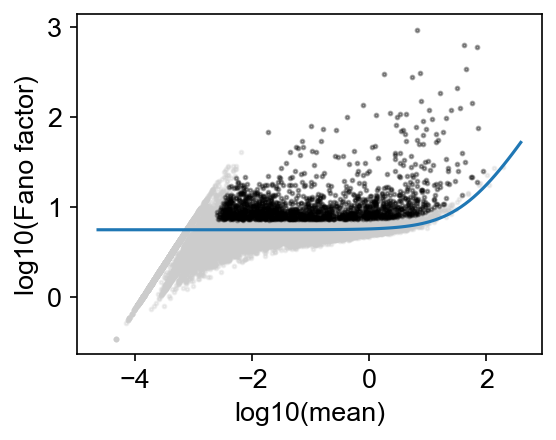

Keeping 1615 genes


In [10]:
cs.pp.get_highly_variable_genes(adata_orig,normalized_counts_per_cell=10000,min_counts=3, 
        min_cells=3, min_gene_vscore_pctl=90)

Compute for each gene its correlation with a set of cell cycle genes. The default cell cycle genes are for mouse.
You need to use your own genes for a different species. This step is optional, but recommended. 

adata.var['highly_variable'] not updated.
Please choose corr_threshold properly, and set confirm_change=True


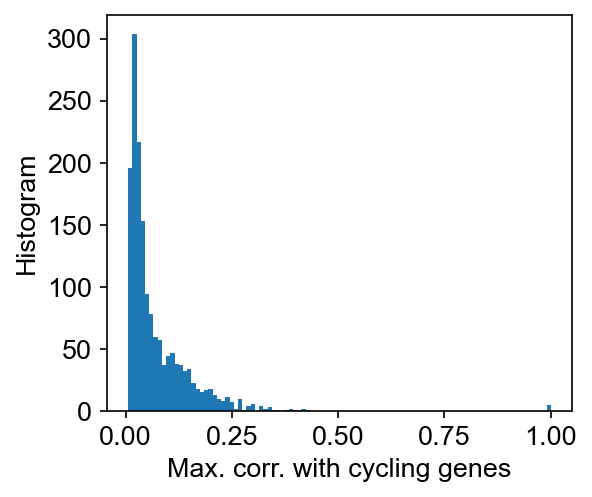

In [11]:
cs.pp.remove_cell_cycle_correlated_genes(adata_orig,cycling_gene_list=['Ube2c','Hmgb2', 'Hmgn2', 'Tuba1b', 'Ccnb1', 'Tubb5', 'Top2a','Tubb4b'])

Now, confirm the change at a specific cutoff threshold. 

In [12]:
cs.pp.remove_cell_cycle_correlated_genes(adata_orig,corr_threshold=0.2,confirm_change=True)

Number of selected non-cycling highly variable genes: 1508
Remove 107 cell cycle correlated genes.
adata.var['highly_variable'] updated


Compute the `X_pca`, `X_emb`, and `state_info` (from clustering). `X_pca` will be used to build the similarity matrix later. `X_emb` is only used for visualization. You can also pass your favorite embedding directly to 
`adata.obsm['X_emb']`.

In [13]:
update=True
if update:
    cs.pp.get_X_pca(adata_orig,n_pca_comp=40) 
    cs.pp.get_X_emb(adata_orig,n_neighbors=20,umap_min_dist=0.3) #Do not run this, as we want to keep the original embedding
    #cs.pp.get_state_info(adata_orig,n_neighbors=20,resolution=0.5) # Do not run this, as we want to keep the original state annotation.

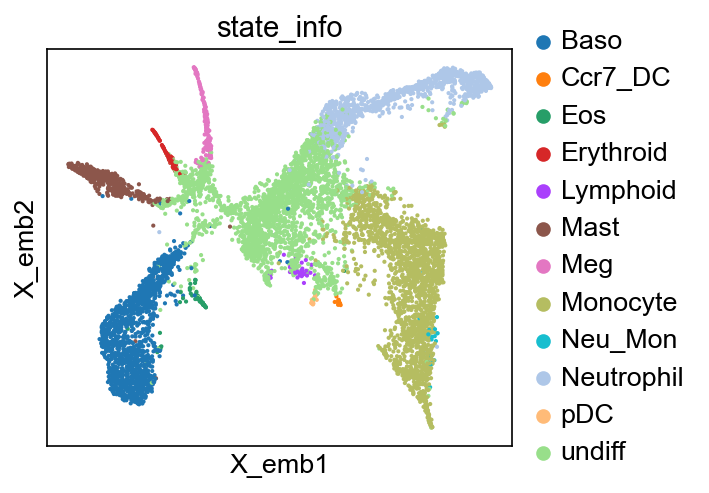

<Figure size 300x262.5 with 0 Axes>

In [14]:
cs.pl.embedding(adata_orig,color='state_info')

In [15]:
adata_orig

AnnData object with n_obs × n_vars = 7438 × 25289
    obs: 'time_info', 'state_info', 'n_counts'
    var: 'highly_variable', 'highly_variable_old'
    uns: 'clonal_time_points', 'data_des', 'neighbors', 'state_info_colors', 'time_ordering', 'umap'
    obsm: 'X_clone', 'X_emb', 'X_emb_old', 'X_pca', 'X_pca_old', 'X_umap'
    obsp: 'connectivities', 'distances'

We use the original embedding for downstream analysis and visualization.

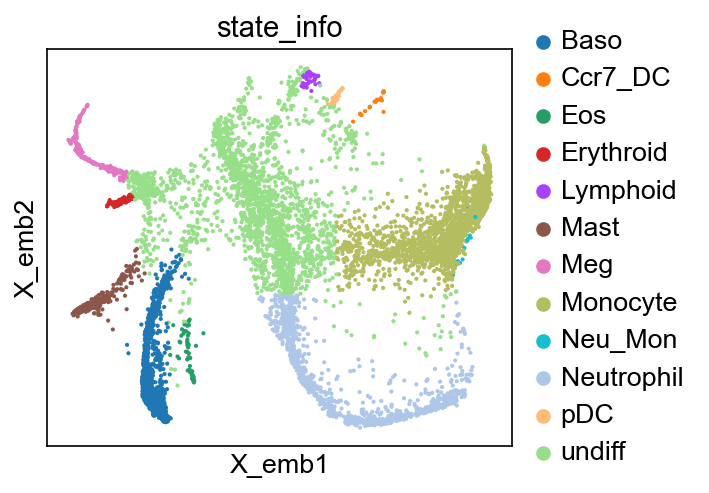

<Figure size 300x262.5 with 0 Axes>

In [16]:
adata_orig.obsm['X_emb']=adata_orig.obsm['X_emb_old']
adata_orig.obsm['X_pca']=adata_orig.obsm['X_pca_old']
cs.pl.embedding(adata_orig,color='state_info')

In [17]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Available clusters: ['Ccr7_DC', 'Eos', 'Mast', 'Neu_Mon', 'Baso', 'Neutrophil', 'undiff', 'pDC', 'Meg', 'Monocyte', 'Erythroid', 'Lymphoid']
Available time points: ['2' '4' '6']
Clonal time points: ['2' '4' '6']


You can choose to save preprocessed data. It can be loaded using `cs.hf.read(file_name)`. 

In [18]:
save=True
if save:
    cs.hf.save_preprocessed_adata(adata_orig)

Saved file: data_cospar/LARRY_sp500_ranking1_adata_preprocessed.h5ad


### Basic clonal analysis

Barcode data aggregated into given fate clusters

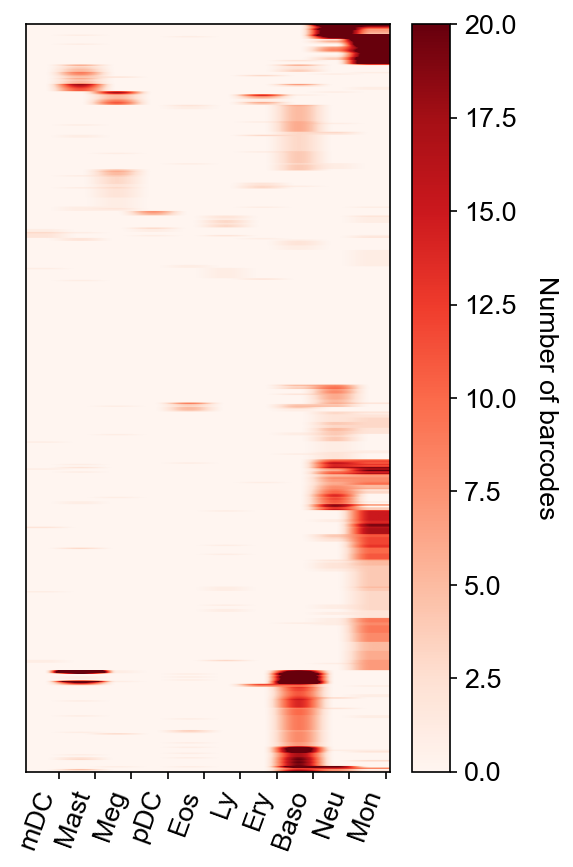

In [19]:
selected_times=None
selected_fates=['Ccr7_DC','Mast','Meg','pDC','Eos','Lymphoid','Erythroid','Baso',  'Neutrophil', 'Monocyte']
celltype_names=['mDC',  'Mast', 'Meg', 'pDC', 'Eos', 'Ly', 'Ery', 'Baso', 'Neu', 'Mon']
cs.pl.barcode_heatmap(adata_orig,selected_times=selected_times, selected_fates=selected_fates, 
        color_bar=True,rename_fates=celltype_names,log_transform=False)

Fate coupling in the underlying clonal data, defined in our package as the normalized barcode covariance between cells annotated in different fates.

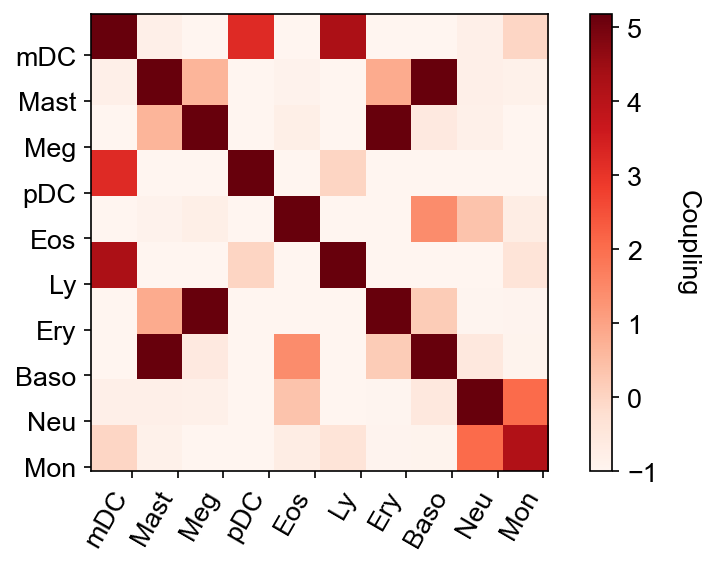

In [20]:
selected_times=None
coupling=cs.pl.fate_coupling_from_clones(adata_orig,selected_times=selected_times, selected_fates=selected_fates, 
                                color_bar=True,rename_fates=celltype_names,method='Weinreb')

Fate hierarchy constructed from fate coupling of the underlying clonal data, using the neighbor-joining method.


            /-Lymphoid
         /-|
        |   \-Ccr7_DC
      /-|
     |  |   /-Monocyte
     |   \-|
     |      \-Neutrophil
   /-|
  |  |         /-Baso
  |  |      /-|
  |  |   /-|   \-Mast
  |  |  |  |
--|   \-|   \-Eos
  |     |
  |     |   /-Erythroid
  |      \-|
  |         \-Meg
  |
   \-pDC


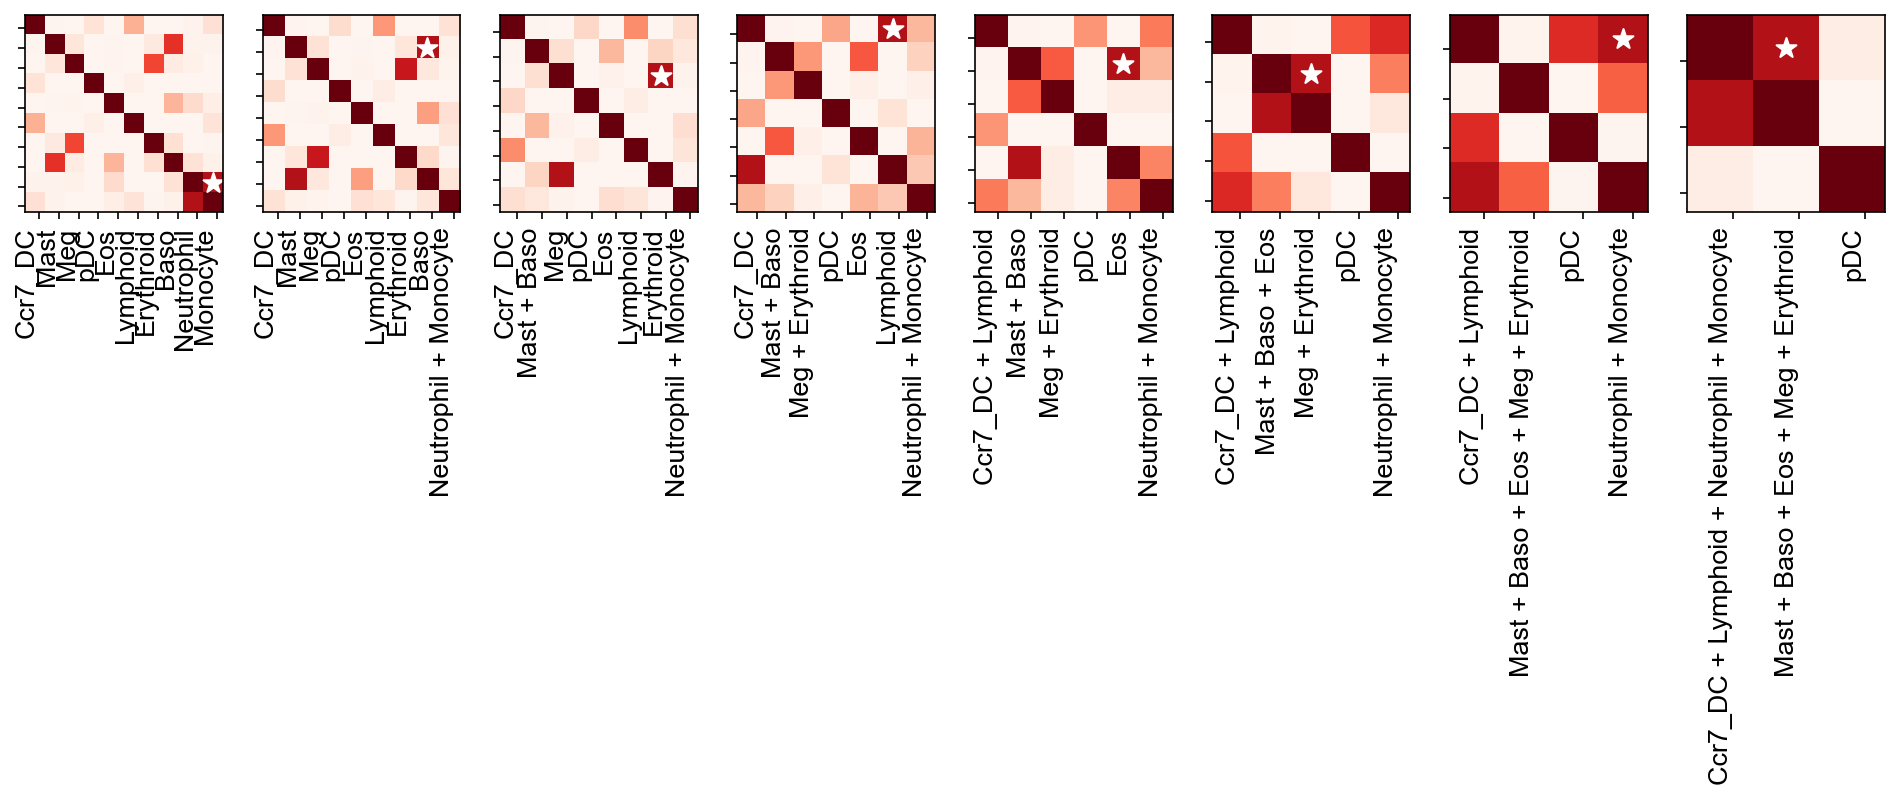

In [21]:
cs.pl.fate_hierarchy_from_clones(adata_orig,selected_times=selected_times,selected_fates=selected_fates,plot_history=True)

Next, we compute the clonal fate bias, -log(Q-value). We calculated a P-value that that a clone is enriched (or depleted) in a fate, using Fisher-Exact test (accounting for clone size). The P-value is then corrected to give a Q-value by Benjamini-Hochberg procedure. The alternative hypothesis options are: {'two-sided','greater','less'}. The default is 'two-sided'.
    
    

Current clone id: 0
Current clone id: 50
Current clone id: 100
Current clone id: 150
Current clone id: 200
Current clone id: 250
Current clone id: 300
Current clone id: 350
Current clone id: 400
Current clone id: 450


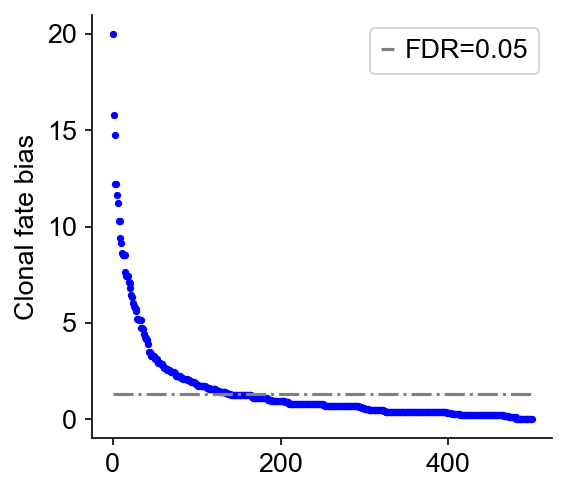

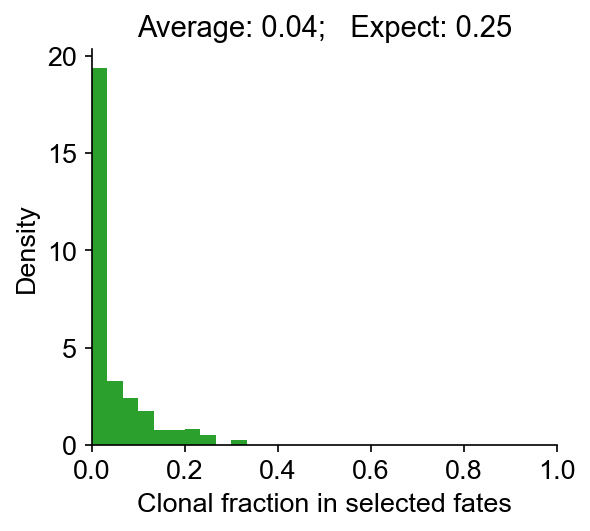

In [22]:
result=cs.pl.clonal_fate_bias(adata_orig,selected_fate='Monocyte',alternative='two-sided')

In [23]:
result

Clone ID  Clone size       Q_value  Fate bias
0         488          58  1.037416e-20  19.984047
1         387          37  1.608291e-16  15.793635
2         227          45  1.665465e-15  14.778465
3         162          42  6.210001e-13  12.206908
4         302         112  6.210001e-13  12.206908
..        ...         ...           ...        ...
495       366           9  1.000000e+00  -0.000000
496        46          18  1.000000e+00  -0.000000
497       408          27  1.000000e+00  -0.000000
498         6           4  1.000000e+00  -0.000000
499       463           3  1.000000e+00  -0.000000

[500 rows x 4 columns]

Illustrate some most biased clones.

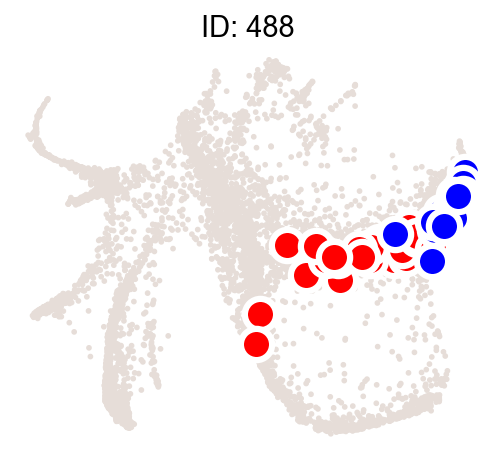

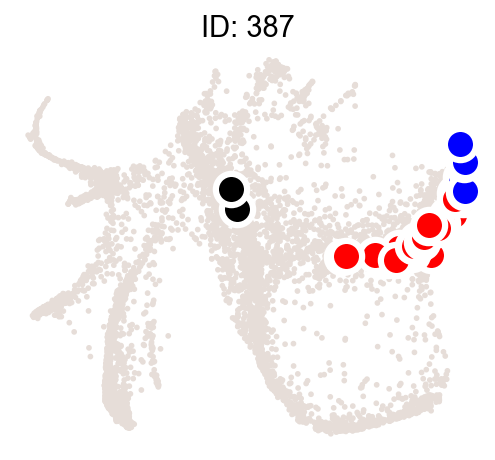

In [24]:
ids=result['Clone ID'][:2]
cs.pl.clones_on_manifold(adata_orig,selected_clone_list=ids,color_list=['black','red','blue'],clone_point_size=10)

## Transition map inference

### Transition map from clones across multiple time points

This method utilizes clones with multiple time points. It is the core algorithm for the CoSpar package. The first time it runs, it will compute the similarity matrix at different smooth depth and save them. Then, it will infer the transition map. Some key parameters:
    
* **clonal_time_points** (`list`; default: all): List of time points with clonal data that you want to perform inference.
    
* **later_time_point** (`str`; default: None): If not set, CoSpar learns a transition map between neighboring time points specified by clonal_time_points, i.e., transitions from day 2 to day 4, and from day 4 to day 6 if clonal_time_points=['2','4','6']. Ohterwise, it learns transitions from any of `clonal_time_points` to the `later_time_point`.
    
* **smooth_array** (`list`; default: [15,10,5]): List of smooth depth at initial runs of iteration. Suppose that it has a length N. For iteration n<N, the n-th entry of smooth_array determines the kernel exponent to build the S matrix at the n-th iteration. When n>N, we use the last entry of smooth_array to compute the S matrix. We recommend starting with more smoothing depth and gradually reduce the depth, as inspired by simulated annealing. Data with higher clonal dispersion should start with higher smoothing depth. The final depth should depend on the manifold itself. For fewer cells, it results in a small KNN graph, and a small final depth should be used. We recommend to use a number at the multiple of 5 for computational efficiency i.e., smooth_array=[20, 15, 10, 5], or [20,15,10].
    
* **sparsity_threshold** (`float`; default: 0.1): sparsity threshold to remove spurious transitions in the updated transition map, in the range [0,1].

* **max_iter_N** (`int`; default: 5): maximum number of iterations in refining the transition map. We found that 3 iterations are sufficient for tested datasets.

* **epsilon_converge** (`float`; default: 0.05): Iteration is considered converged when the correlation R between maps from consecutive iteration satisfies: R>1-`epsilon_converge`.  

It takes ~3 mins to run for the first time, and ~20 s for later runs. 

In [25]:
adata=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig,clonal_time_points=['2','4'], 
                    later_time_point='6',smooth_array=[20,15,10,5],
          sparsity_threshold=0.1,intraclone_threshold=0.2,max_iter_N=10,epsilon_converge=0.01)


Trying to set attribute `.uns` of view, copying.


------Compute the full Similarity matrix if necessary------
------Infer transition map between initial time points and the later time one------
--------Current initial time point: 2--------
Step 1: Select time points
Number of multi-time clones post selection: 185
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.942
Iteration 5, Use smooth_round=5
Convergence (CoSpar, iter_N=5): corr(previous_T, current_T)=0.996
--------Current initial time point: 4--------
Step 1: Select time points
Number of multi-time clones post selection: 500
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Iteration 4, Use smooth_round=5
Convergence (CoSpar,

We can see that after this step, we have two maps: `'transition_map'` and `'intraclone_transition_map'`. Both of them can be used 
    for downstream analysis. 

In [26]:
cs.hf.check_available_map(adata)
adata.uns['available_map']

['transition_map', 'intraclone_transition_map']

### Transition map from end-point clones, or without clones

After initializing the map by either the `OT` or `HighVar` method, We jointly infer the likely clonal ancestors and the corresponding transition map between given time points. You need to choose the initialization method and set the corresponding parameters.

* **initialize_method**=`OT`: using optimal transport. Key parameters: 
        
    * **OT_epsilon** (`float`; default: 0.02): the entropic regularization 
    
    * **OT_cost** ({`GED`, `SPD`}, default: `SPD`): method for computing the cost function. `GED` uses simple gene expression distances; it is faster. `SPD` uses the shortest path distances; it is slower but often more accurate. 

* **initialize_method**=`HighVar`: `HighVar` assumes that cells similar in gene expression across time points share clonal origin. It converts highly variable genes into pseudo multi-time clones and runs ``cs.tmap.infer_Tmap_from_multitime_clones`` to construct the map. We find `HighVar` performs better than `OT`, especially when there are large differentiation effects over the observed time window, or batch effects.

    * **HighVar_gene_pctl** (`int`; default: 85): percentile threshold to select highly variable genes. Range: [0,100]. A higher value selects more variable genes. 
            
* **max_iter_N** (`list`; default: [3,5]): a list of two entries, representing the maximum iteration number for joint optimization and CoSpar core function, respectively. 
    
* **epsilon_converge** (`list`; default: [0.05,0.05]), a list of two entries, indicating the map convergence threshold for joint optimization and CoSpar core function, respectively. 

Infer transition map from a single clonal time point (using `OT`), please run ( ~ 1 min): 

In [27]:
adata_1=cs.tmap.infer_Tmap_from_one_time_clones(adata_orig,initial_time_points=['4'],
        later_time_point='6',initialize_method='OT',OT_cost='GED',
                smooth_array=[20,15,10,5],sparsity_threshold=0.1)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: 4--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use OT method for initialization-------
Load pre-computed custom OT matrix
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.961
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.297
-----JointOpt Iteration 2: Infer initial clonal structure
-----JointOpt Iteration 2: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Itera

In [28]:
cs.hf.check_available_map(adata_1)
adata_1.uns['available_map']

['transition_map', 'OT_transition_map']

Infer transition map from state information alone (using `HighVar`): (it takes ~ 2 mins)

In [29]:
adata_2=cs.tmap.infer_Tmap_from_state_info_alone(adata_orig,initial_time_points=['4'],
        later_time_point='6',initialize_method='HighVar',HighVar_gene_pctl=85,max_iter_N=[10,10],
    epsilon_converge=[0.01,0.01],smooth_array=[20,15,10,5],sparsity_threshold=0.1)

Step I: Generate pseudo clones where each cell has a unique barcode-----


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


Step II: Perform joint optimization-----
--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: 4--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use the HighVar method for initialization-------
Step a: find the commonly shared highly variable genes------
Highly varable gene number: 2136 (t1); 2245 (t2). Common set: 978
Step b: convert the shared highly variable genes into clonal info------
Total used genes=853 (no cells left)
Step c: compute the transition map based on clonal info from highly variable genes------
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.965
Iteration 5, Use smooth_round=5
Convergence (CoSpar, iter_N=5): corr(previous_T, current_T)=0.992
Finishing initialization using HighVar, used time 32.3679161

In [30]:
cs.hf.check_available_map(adata_2)
adata_2.uns['available_map']

['transition_map', 'HighVar_transition_map']

### Transition map from clonal data alone, without state information

As a comparision, we can also learn the transition map using clonal information alone:

In [31]:
# We use the Weinreb method, which selects uni-potent clones based on a pre-defined list of fates.
selected_fates=['Baso', 'Ccr7_DC', 'Eos', 'Erythroid', 'Lymphoid', 'Mast', 'Meg', 'Monocyte', 'Neu_Mon', 'Neutrophil', 'pDC']

adata_3=cs.tmap.infer_Tmap_from_clonal_info_alone(adata_orig,method='weinreb',later_time_point='6',selected_fates=selected_fates)

Trying to set attribute `.uns` of view, copying.


Infer transition map between initial time points and the later time point.
--------Current initial time point: 2--------
Number of multi-time clones post selection: 185
Use only uni-potent clones (weinreb et al., 2020)
Used uni-potent clone fraction 0.6162162162162163
--------Current initial time point: 4--------
Number of multi-time clones post selection: 500
Use only uni-potent clones (weinreb et al., 2020)
Used uni-potent clone fraction 0.538


In [32]:
cs.hf.check_available_map(adata_3)
adata_3.uns['available_map']

['clonal_transition_map']

## Save or load pre-computed data (optional)

This can be used to save adata with maps computed from different tools or parameters.
Usually, different parameter choices will result in different `data_des`, a prefix to identify the anndata.
Saving an adata will print the file path, which can be used to re-load the adata via `cs.hf.read(file_name)`. 

In [33]:
save_data=False
if save_data:
    cs.hf.save_map(adata)
    
load_data=False
if load_data:
    file_path='data_cospar/LARRY_sp500_ranking1_MultiTimeClone_Later_FullSpace0_t*2*4*6_adata_with_transition_map.h5ad'
    adata=cs.hf.read(file_path)

## Plotting

There are some common parameters:

* **used_Tmap** (`str`; default: `transition_map`). It determines which transition map to use for analysis. Choices: {`transition_map`, `intraclone_transition_map`, `OT_transition_map`, `HighVar_transition_map`, `clonal_transition_map`}

* **selected_fates** (`list` of `str`). Selected clusters to aggregate differentiation dynamics and visualize fate bias etc.. It allows nested structure, e.g., selected_fates=[‘a’, [‘b’, ‘c’]] selects two clusters: cluster ‘a’ and the other that combines ‘b’ and ‘c’.

* **map_backward** (`bool`; default: True). We can analyze either the backward transitions, i.e., where these selected states or clusters came from (`map_backward=True`); or the forward transitions, i.e., where the selected states or clusters are going (`map_backward=False`).

* **selected_times** (`list`; default: all). List of time points to use. By default, all are used. 

* **method** (`str`; default: `norm-sum`). Method to aggregate the transition probability within a cluster. Choices: {`norm-sum`,`sum`}. `norm-sum` returns the probability that a fate cluster originates from an early state *i*; while `sum` gives the probability that an initial state *i* gives rise to a fate cluster.  

### Plotting transition profiles for single cells

First, check the forward transitions (i.e., future states) from the `'transition_map'`.

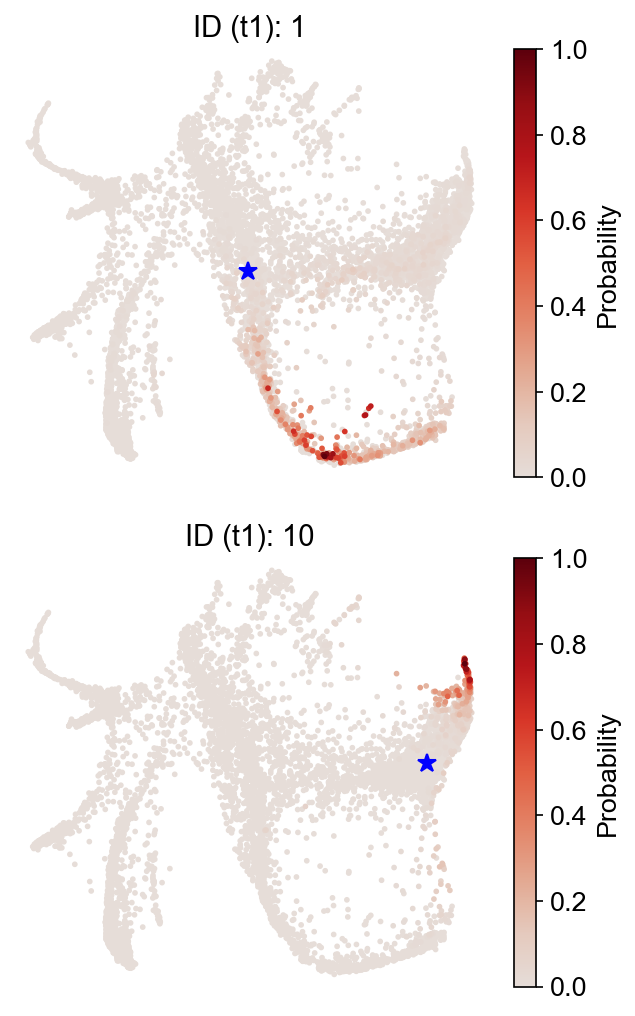

In [34]:
selected_state_id_list=[1,10] # This is a relative ID. Its mapping to the actual cell id depends on map_backward.

map_backward=False
cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                used_Tmap='transition_map',map_backward=map_backward)

Now, backward transitions (i.e., past states) from the same map.

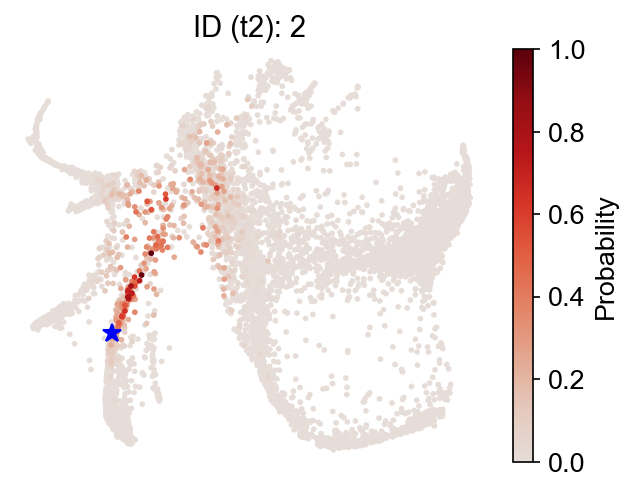

In [35]:
selected_state_id_list=[2]
map_backward=True
cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                    used_Tmap='transition_map',map_backward=map_backward)

Finally, switch to the `'intraclone_transition_map'`, and check the observed clonal transitions:

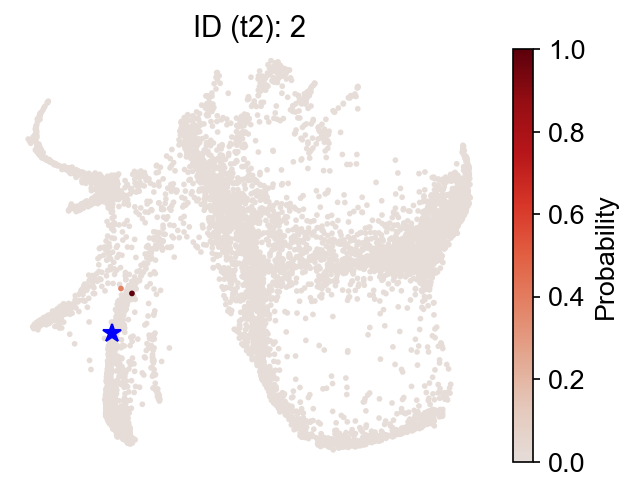

In [36]:
selected_state_id_list=[2] 
map_backward=True
cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                                    used_Tmap='intraclone_transition_map',map_backward=map_backward)

### Fate map

Inspect the backward transitions, and ask where the selected fate clusters come from.

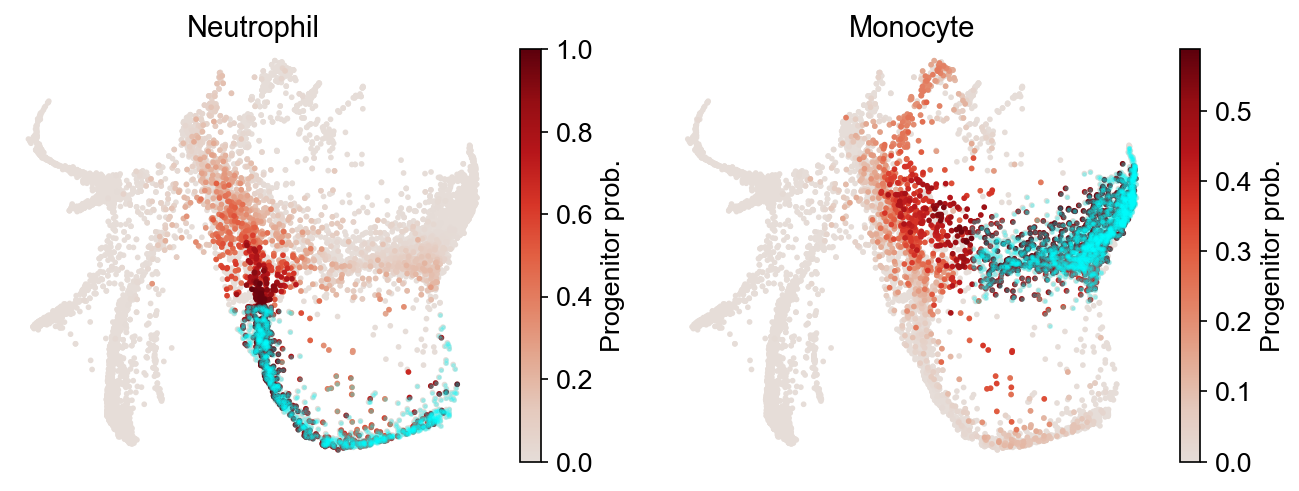

In [37]:
cs.pl.fate_map(adata,selected_fates=['Neutrophil','Monocyte'],
               used_Tmap='transition_map',map_backward=True,plot_target_state=True,horizontal=True)

The results are stored at `adata.obs[f'fate_map_{fate_name}']` for each corresponding `fate_name`. They can be used for downstream analysis. As an example, you can visualize the fate map again in this way:

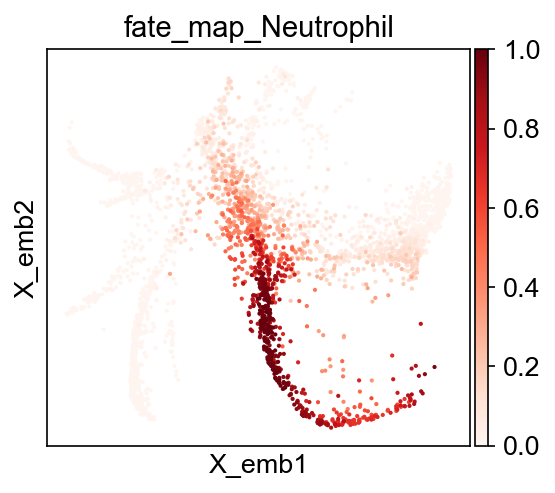

<Figure size 300x262.5 with 0 Axes>

In [38]:
cs.pl.embedding(adata,color='fate_map_Neutrophil')

### Fate potency

Count fate number directly (`fate_count=True`); otherwise, calculate the potencyusing entropy. The results are stored at `adata.obs['fate_potency']`

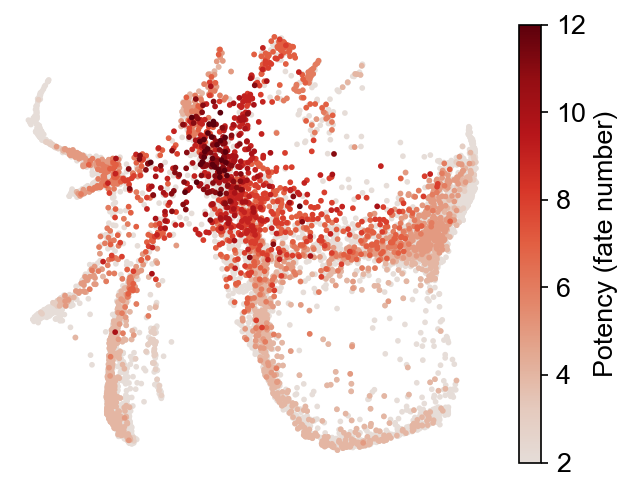

In [39]:
fate_entropy=cs.pl.fate_potency(adata,used_Tmap='transition_map',
            map_backward=True,method='norm-sum',color_bar=True,fate_count=True)

### Fate bias

The fate bias of an initial state *i* is defined by the competition of fate probability towards two fate clusters A and B: 
    
* Bias_i=`P(i;A)/[P(i;A)+P(i;B)]`.
    
Only states with fate probabilities satisfying this criterion will be shown: 

* P(i; A)+P(i; B)>sum_fate_prob_thresh

The inferred fate bias is stored at `adata.obs[f'fate_bias_{fate_1}_{fate_2}']`.

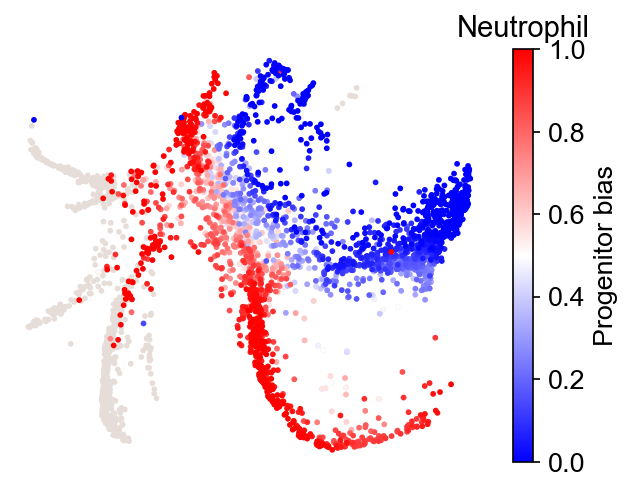

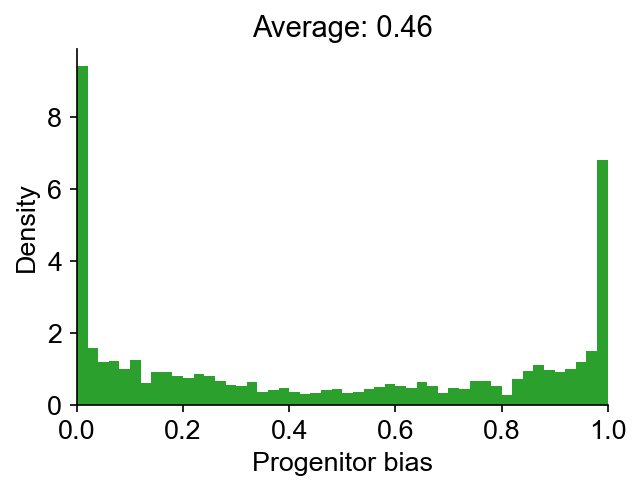

In [40]:
cs.pl.fate_bias(adata,selected_fates=['Neutrophil','Monocyte'],used_Tmap='transition_map',pseudo_count=0,
            plot_target_state=False,map_backward=True,sum_fate_prob_thresh=0.002,method='norm-sum')

We can also study fate bias in the Gata1+ states. First, prepare a sate mask:

In [41]:
x_emb=adata.obsm['X_emb'][:,0]
y_emb=adata.obsm['X_emb'][:,1]

index_2=cs.hf.above_the_line(adata.obsm['X_emb'],[100,500],[500,-1000])
index_5=cs.hf.above_the_line(adata.obsm['X_emb'],[0,-500],[1000,2])
final_mask= (~index_2) & ((index_5 | (x_emb<0))) #& index_3 & index_4 & index_5 #mask_1 &

Now, compute the fate bias. We can concatenate cluster 'Meg' and 'Erythroid' using a nested list. Same for concatenating 'Baso', 'Mast', and 'Eos'. 

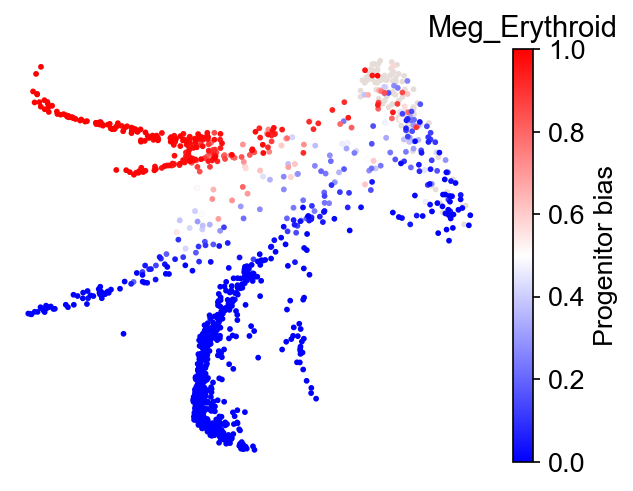

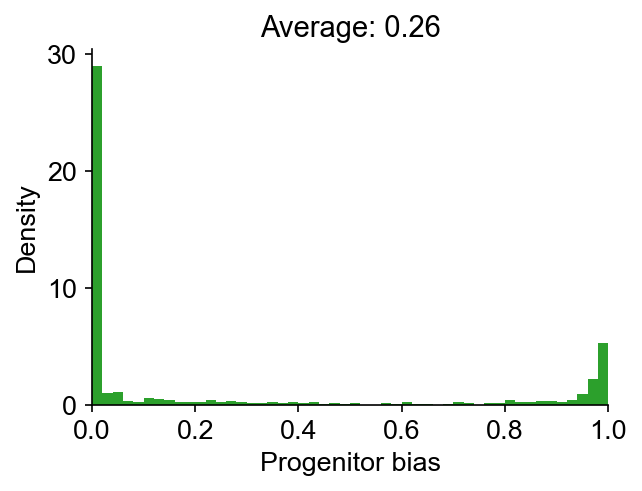

In [42]:
cs.pl.fate_bias(adata,selected_fates=[['Meg','Erythroid'],['Baso','Mast','Eos']],used_Tmap='transition_map',
        plot_target_state=False,mask=final_mask,map_backward=True,sum_fate_prob_thresh=0.01,method='norm-sum')

### Dynamic trajectory inference

We can infer the dynamic trajectory and ancestor population using the fate bias from binary fate competition. Here, fate bias is a scalar between (0,1) at each state. Selected ancestor population satisfies:

   * P(i;A) + P(i;B) > sum_fate_prob_thresh; 

   * Ancestor states {*i*} for A: Bias_i > bias_threshold_A

   * Ancestor states {*i*} for B: Bias_i < bias_threshold_B

They will be stored at `adata.obs['cell_group_A']`,  `adata.obs['cell_group_B']`, and `adata.obs[f'traj_{fate_name}']`. 

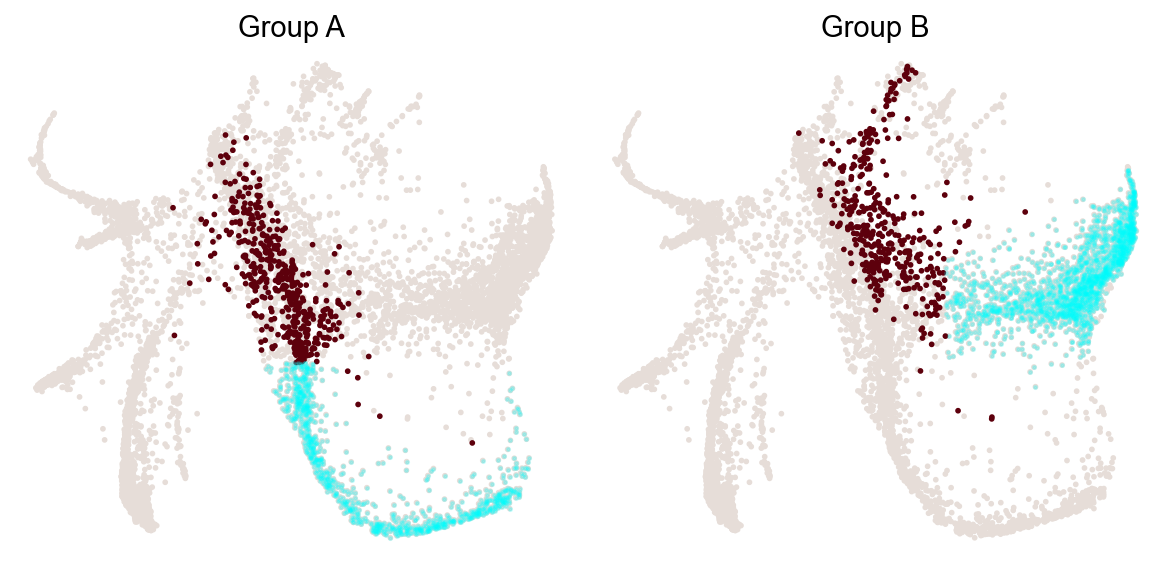

In [43]:
cs.pl.dynamic_trajectory_from_fate_bias(adata, selected_fates=['Neutrophil','Monocyte'], 
 used_Tmap='transition_map', map_backward=True, 
    bias_threshold_A=0.5,bias_threshold_B=0.5, sum_fate_prob_thresh=0.2, avoid_target_states=True)

We can visualize the trajectory directly

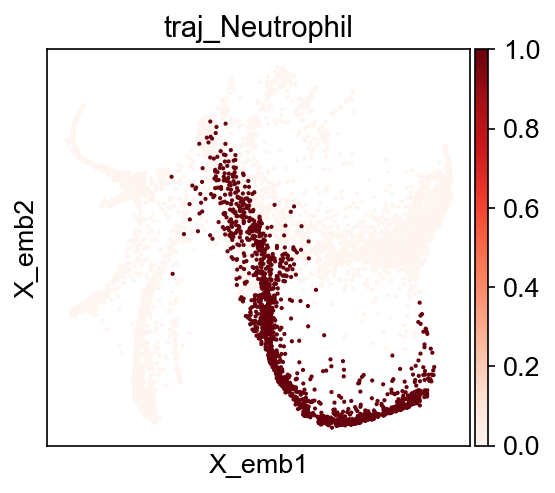

<Figure size 300x262.5 with 0 Axes>

In [44]:
fate_name='Neutrophil' #Monocyte
traj_name=f'traj_{fate_name}'
cs.pl.embedding(adata,color=traj_name)

### Differential genes for two ancestor groups

It would be interesting to see what genes are differentially expressed between these two ancestor populations, which might drive fate bifurcation. We provide a simple differentiation gene expression analysis that uses Wilcoxon rank-sum test to calculate P values, followed by Benjamini-Hochberg correction. You can always use your own method.

This function accepts populations defined in `adata.obs['cell_group_A']` and `adata.obs['cell_group_B']`, which have been generated in the previous step.

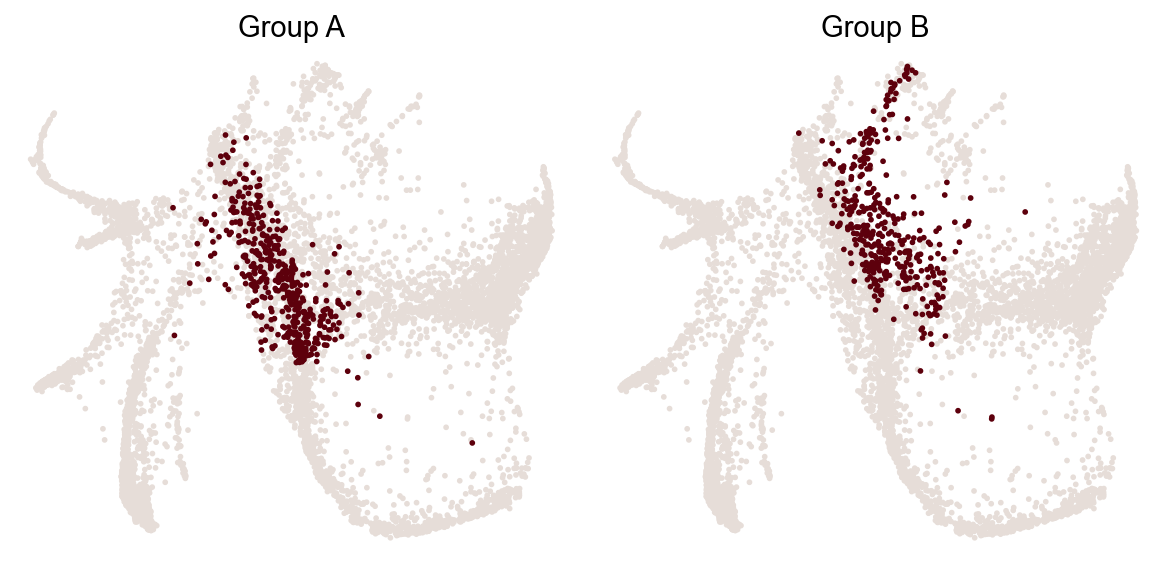

In [45]:
dge_gene_A, dge_gene_B=cs.pl.differential_genes(adata,plot_gene_N=0)

In [46]:
dge_gene_A

index   gene        Qvalue     mean_1     mean_2     ratio
0        2    Mpo  2.990318e-28   2.415750   8.792541 -1.519481
1        1  Elane  4.809145e-29   5.810114  17.454430 -1.438216
2        3  Gstm1  3.437493e-28   3.311963  10.061214 -1.359093
3       86  Gata2  3.905816e-04   0.224528   1.486434 -1.021853
4        0   Srgn  2.129458e-39  37.388157  75.211327 -0.989344
..     ...    ...           ...        ...        ...       ...
188    218  Ube2s  2.074811e-02   1.900290   2.287596 -0.180836
189    120    Pkm  2.156281e-03  17.192078  19.617094 -0.180531
190    158  Rpl12  7.971787e-03  31.622345  35.886330 -0.177226
191    198  Rplp0  1.517882e-02  13.676153  15.563156 -0.174504
192    246  Rps17  3.454934e-02  25.652222  28.897778 -0.165782

[193 rows x 6 columns]

Gene expression can be explored directly:

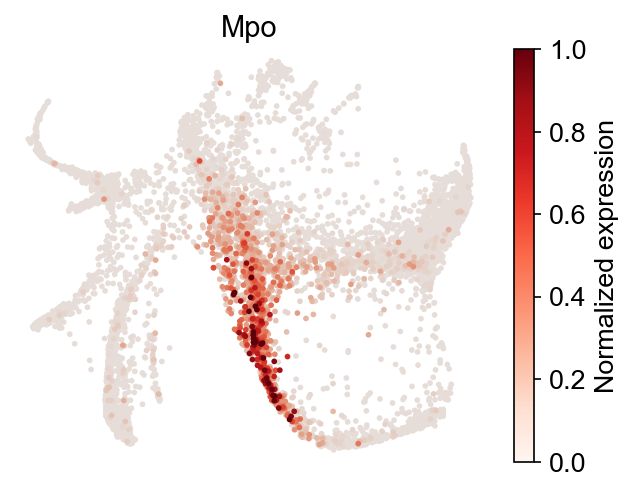

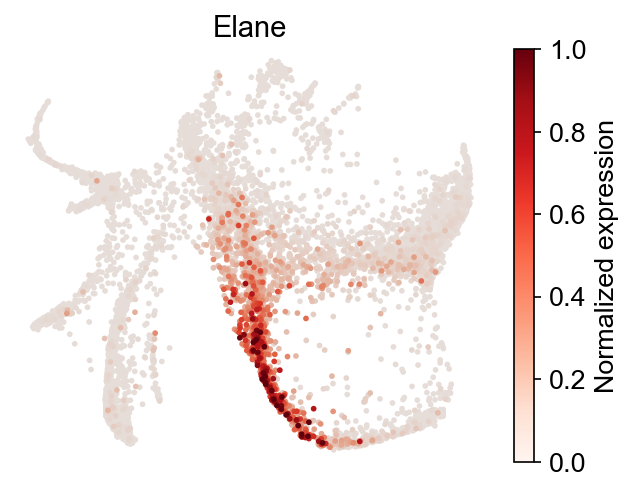

In [47]:
selected_genes=dge_gene_A['gene'][:2]
cs.pl.gene_expression_on_manifold(adata,selected_genes=selected_genes,color_bar=True,savefig=False)

You can visualize the gene expression differences using a heat map.

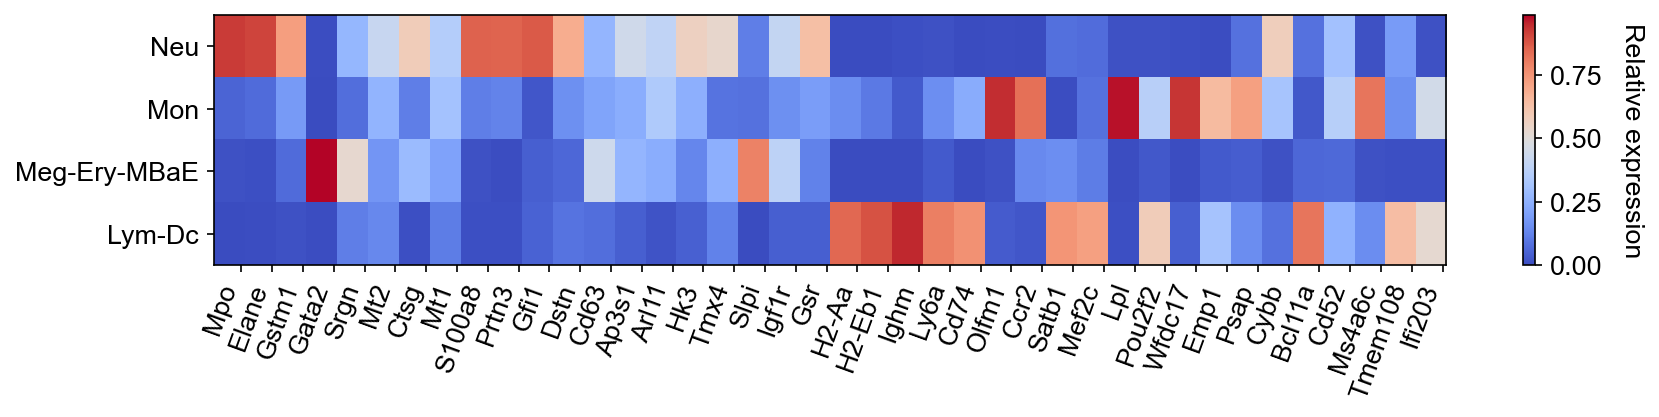

In [48]:
gene_list=list(dge_gene_A['gene'][:20])+list(dge_gene_B['gene'][:20]) #select the top 20 genes from both populations

selected_fates=['Neutrophil','Monocyte',['Baso','Eos','Erythroid','Mast','Meg'],['pDC','Ccr7_DC','Lymphoid']]
renames=['Neu','Mon','Meg-Ery-MBaE','Lym-Dc']

gene_expression_matrix=cs.pl.gene_expression_heat_map(adata,selected_genes=gene_list,selected_fates=selected_fates,
                            rename_fates=renames,fig_width=12)

You can define cell groups by yourself, and run the differential gene expression analysis.

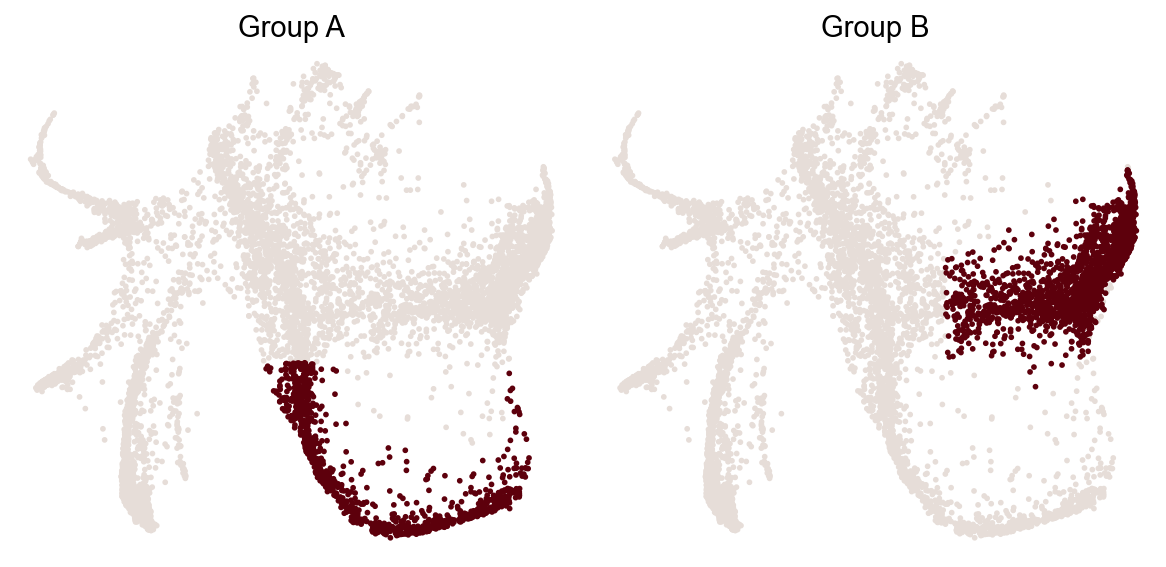

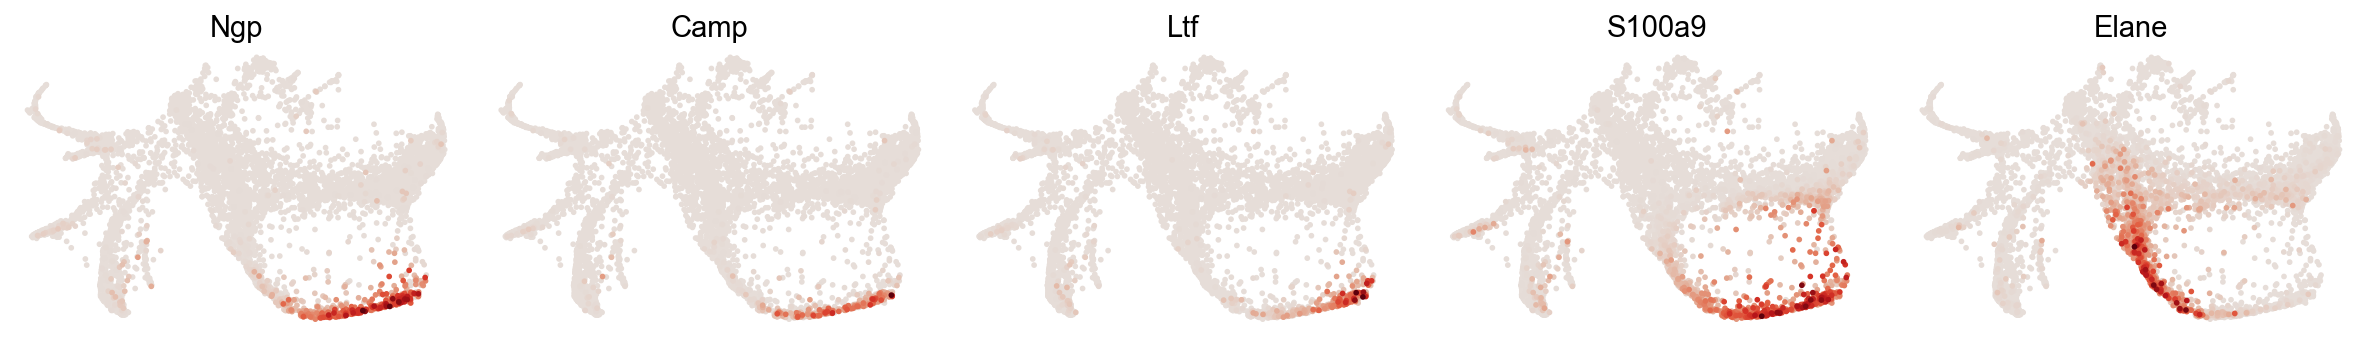

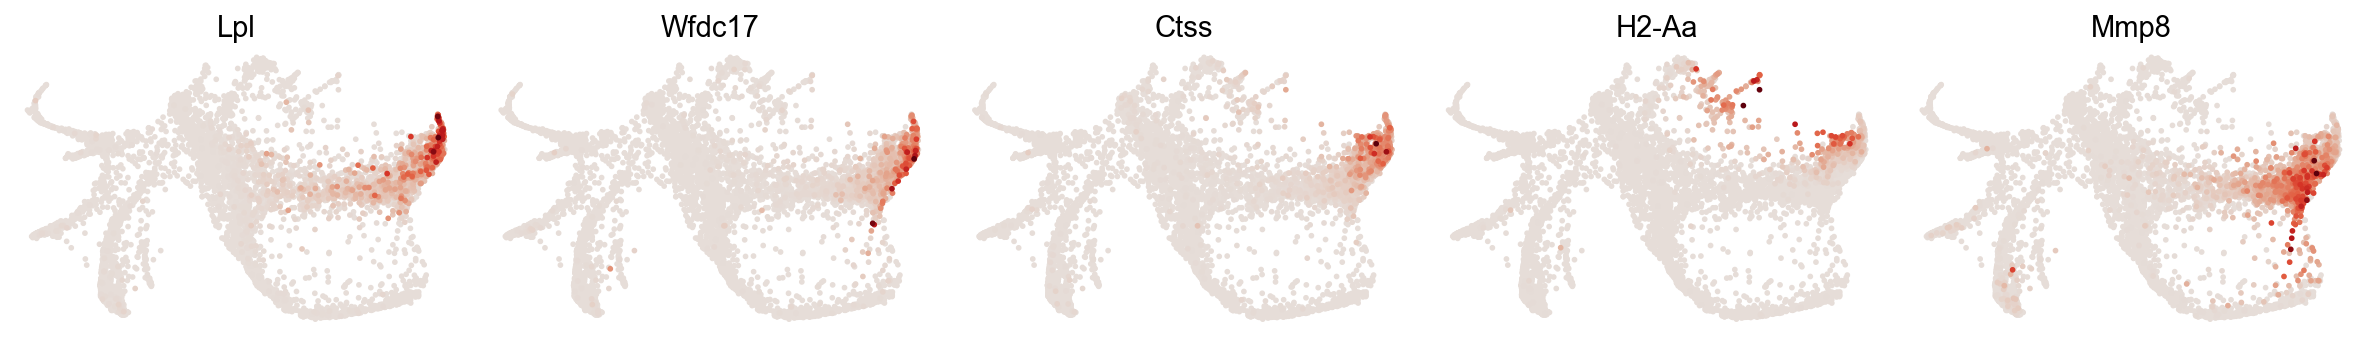

In [49]:
group_A_idx=adata.obs['state_info']=='Neutrophil'
group_B_idx=adata.obs['state_info']=='Monocyte'
dge_gene_A, dge_gene_B=cs.pl.differential_genes(adata,group_A_idx=group_A_idx,group_B_idx=group_B_idx,plot_gene_N=5)

### Gene expression dynamics

We can calculate the pseudotime along an inferred trajectory, and plot the gene expression along the pseudotime. This method requires that a trajectory has been inferred in previously steps.


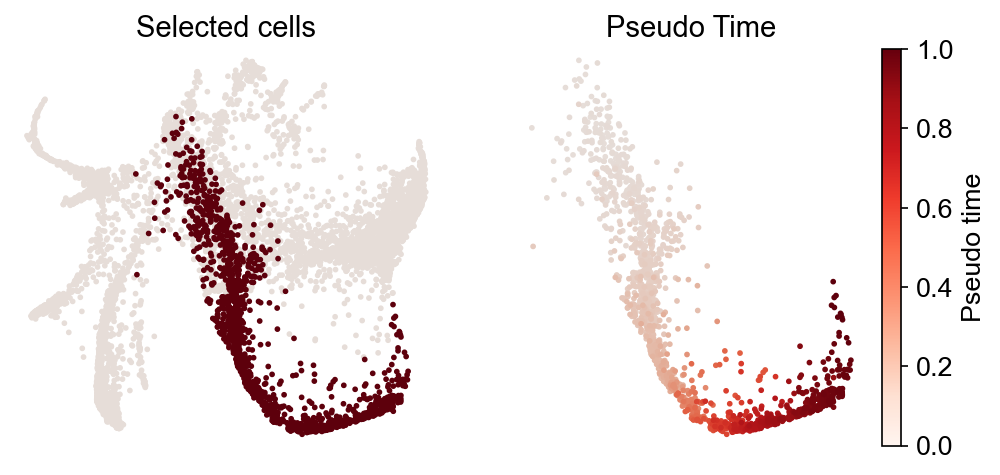

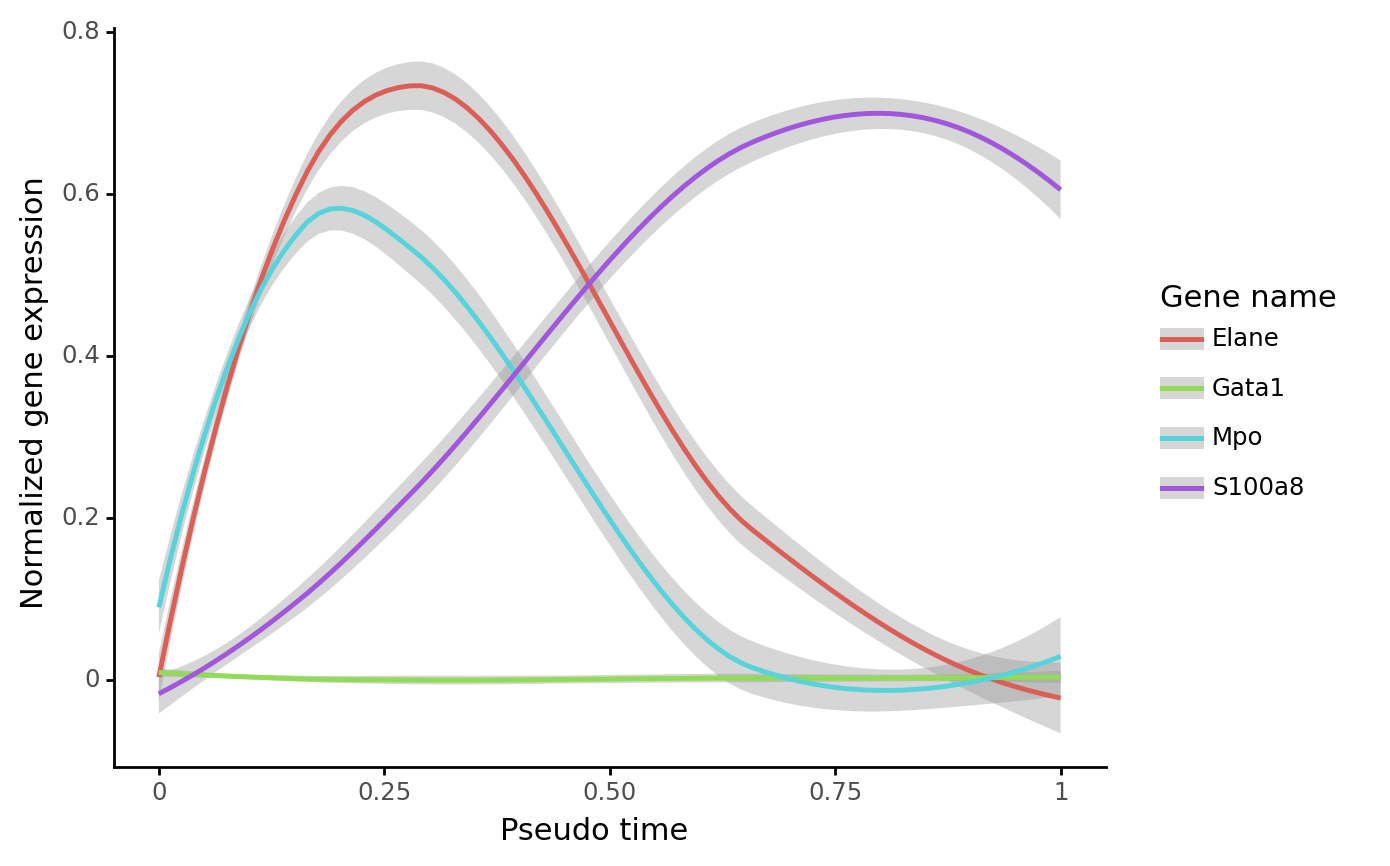

In [50]:
gene_name_list=['Gata1','Mpo', 'Elane', 'S100a8']
selected_fate='Neutrophil'
cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.2,  
    invert_PseudoTime=False, compute_new=True, 
      gene_exp_percentile=99, n_neighbors=8, plot_raw_data=False)

You can perform pseudotime analysis with the selected cell states using any other existing packages for dynamic inference. 

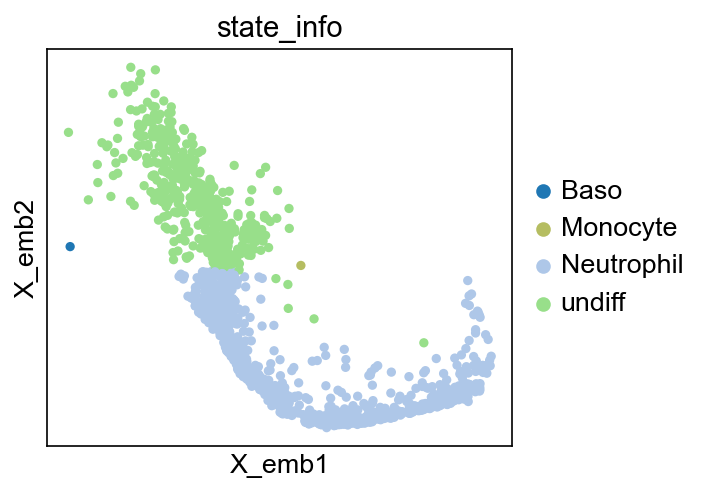

<Figure size 300x262.5 with 0 Axes>

In [51]:
fate_name='Neutrophil' #Monocyte
traj_name=f'traj_{fate_name}'
sub_adata=adata[adata.obs[traj_name]>0] # the sub_adata object is the adata with selected states, which can be used for pseudotime analysis
cs.pl.embedding(sub_adata,color='state_info')

### Fate coupling and hierarchy

The inferred transition map can be used to estimate differentiation coupling between different fate clusters. 

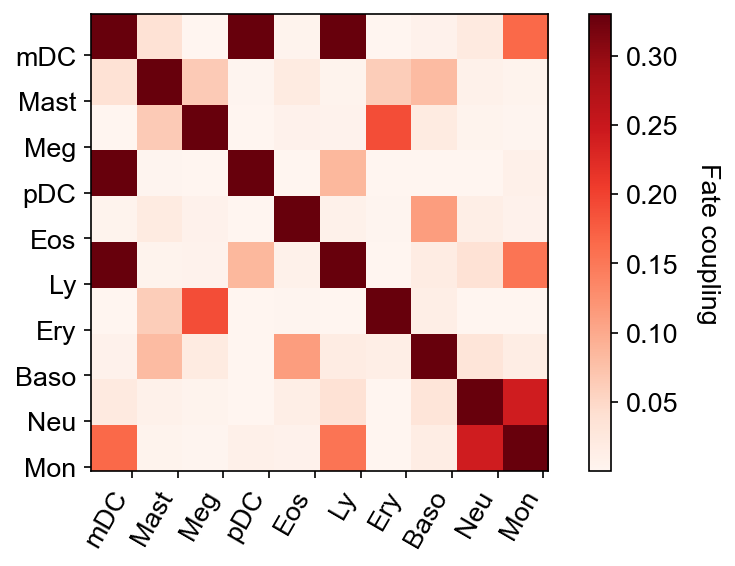

In [52]:
selected_fates=['Ccr7_DC','Mast','Meg','pDC','Eos','Lymphoid','Erythroid','Baso',  'Neutrophil', 'Monocyte']
celltype_names=['mDC',  'Mast', 'Meg', 'pDC', 'Eos', 'Ly', 'Ery', 'Baso', 'Neu', 'Mon']
coupling_matrix=cs.pl.fate_coupling_from_Tmap(adata,selected_fates=selected_fates,used_Tmap='transition_map',
                        rename_fates=celltype_names)


We can also infer fate hierarchy from a transition map, based on the fate coupling matrix and using the neighbor-joining method.


            /-Baso
         /-|
      /-|   \-Eos
     |  |
   /-|   \-Mast
  |  |
  |  |   /-Ery
  |   \-|
--|      \-Meg
  |
  |      /-Mon
  |   /-|
  |  |   \-Neu
   \-|
     |      /-Ly
     |   /-|
      \-|   \-mDC
        |
         \-pDC


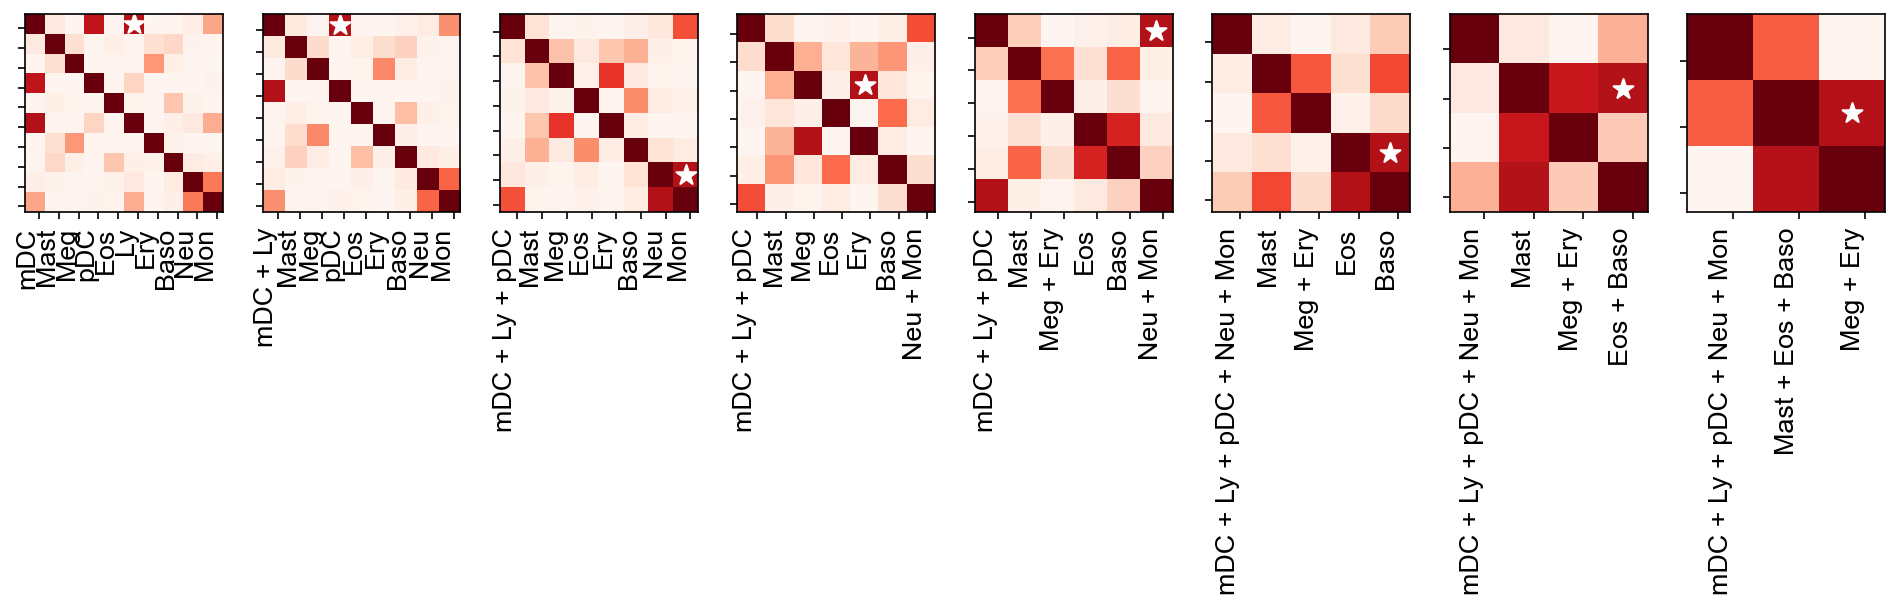

In [53]:
cs.pl.fate_hierarchy_from_Tmap(adata,selected_fates=selected_fates,used_Tmap='transition_map',
                        rename_fates=celltype_names)

## Miscellaneous

### Refine state annotation by marker genes

The goal here is to refine `adata.obs['state_info']`. In this method, a state is selected if it expresses all genes in the list of 
`marker_genes`, and the expression is above the relative threshold `express_threshold`. 
You can also specify which time point you want to focus on. In addition, we also 
include cell states neighboring to these valid states to smooth 
the selection (controlled by `add_neighbor_N`). First, explore parameters to find satisfactory annotation.

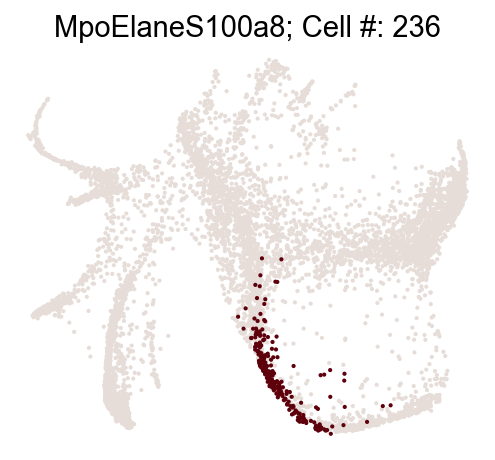

In [54]:
confirm_change=False
marker_genes=['Mpo', 'Elane', 'S100a8']
cs.pp.refine_state_info_by_marker_genes(adata,marker_genes,express_threshold=0.1,
    selected_times=['4'],new_cluster_name='new',add_neighbor_N=10,confirm_change=confirm_change)

Once you are happy with the result, set `confirm_change=True` to confirm changes to `adata.obs['state_info']`.

### Refine state annotation by clustering states at given time points

First, explore the parameters.

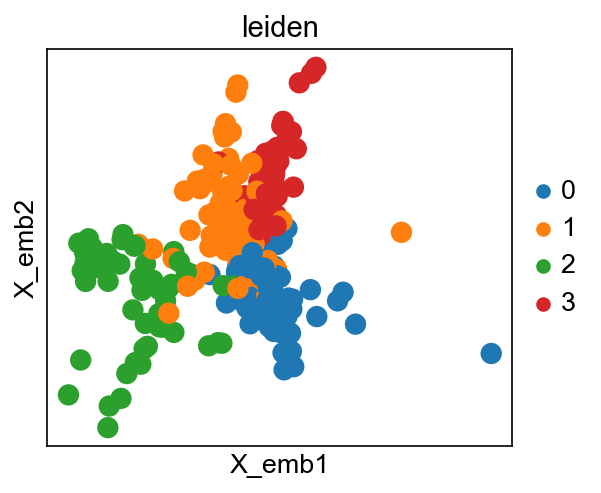

<Figure size 300x262.5 with 0 Axes>

In [55]:
confirm_change=False
cs.pp.refine_state_info_by_leiden_clustering(adata,selected_times=['2'],n_neighbors=20,
            resolution=0.5,confirm_change=confirm_change)

Once you are happy with the result, set `confirm_change=True` to confirm changes to `adata.obs['state_info']`.

### Differential gene expression between two clusters

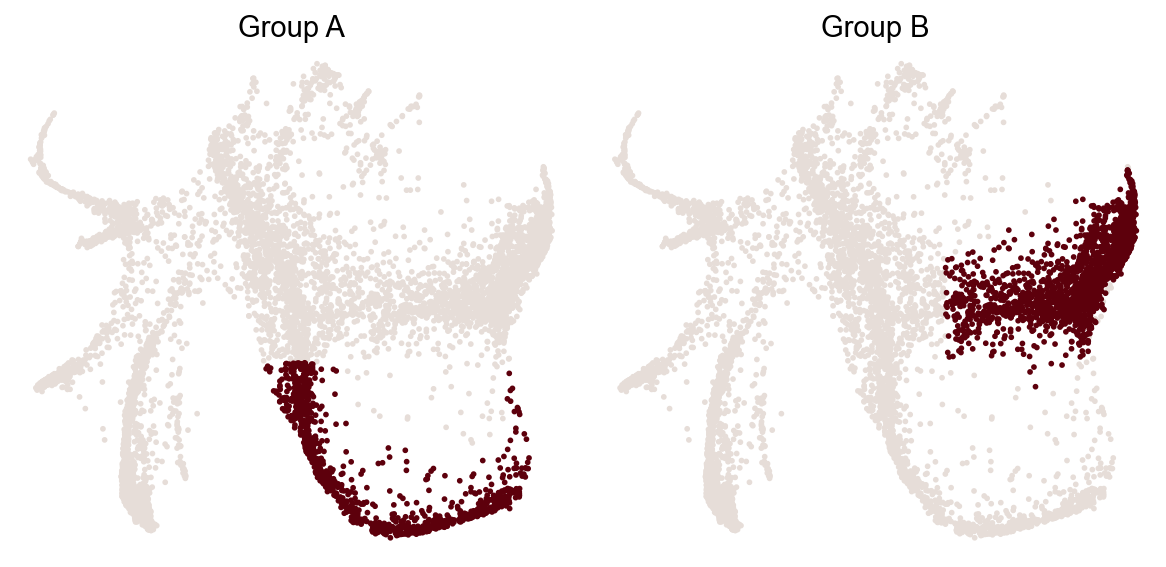

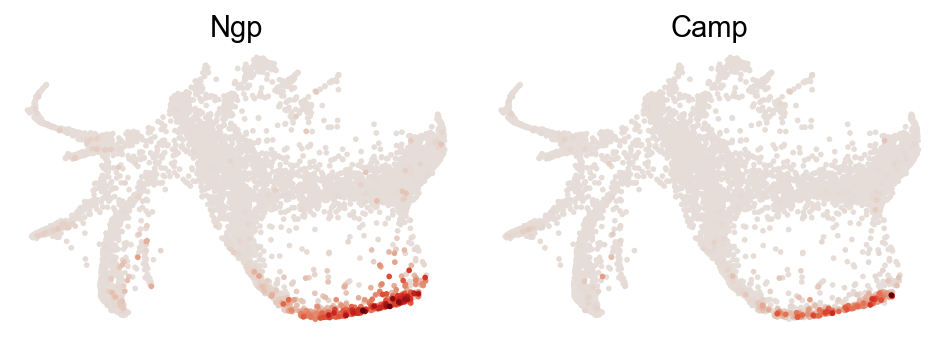

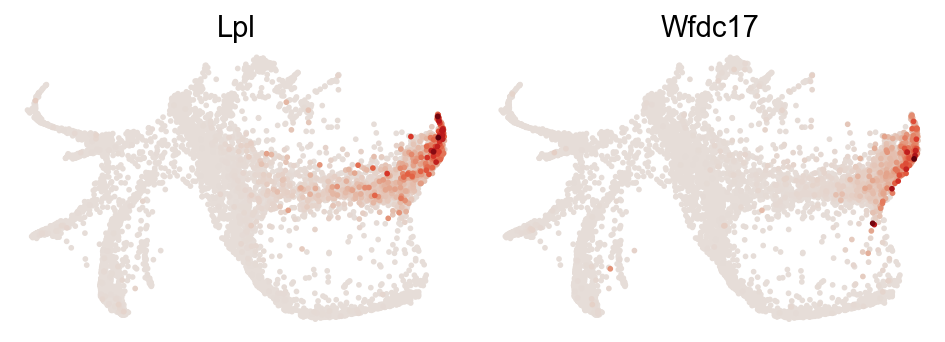

In [56]:
diff_gene_A,diff_gene_B=cs.pl.differential_genes_for_given_fates(adata,
            selected_fates=['Neutrophil','Monocyte'],plot_gene_N=2)

### Propagate a cluster in time

One way to define the dynamic trajectory is simply mapping a given fate cluster backward in time. The whole trajectory across multiple time points will be saved at `adata.obs[f'traj_{fate_name}']`. This method requires having multiple clonal time points, and a transition map between neighboring time points. 



First, use all clonal time points (the default), and infer a transition map between neighboring time points (by not setting `later_time_point`).

In [57]:
adata_5=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig,smooth_array=[20,15,10,5],
          sparsity_threshold=0.2,intraclone_threshold=0.2,max_iter_N=10,epsilon_converge=0.01)

------Compute the full Similarity matrix if necessary------
----Infer transition map between neighboring time points-----
Step 1: Select time points
Number of multi-time clones post selection: 500
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.912
Iteration 5, Use smooth_round=5
Convergence (CoSpar, iter_N=5): corr(previous_T, current_T)=0.993
-----------Total used time: 16.729663848876953 s ------------


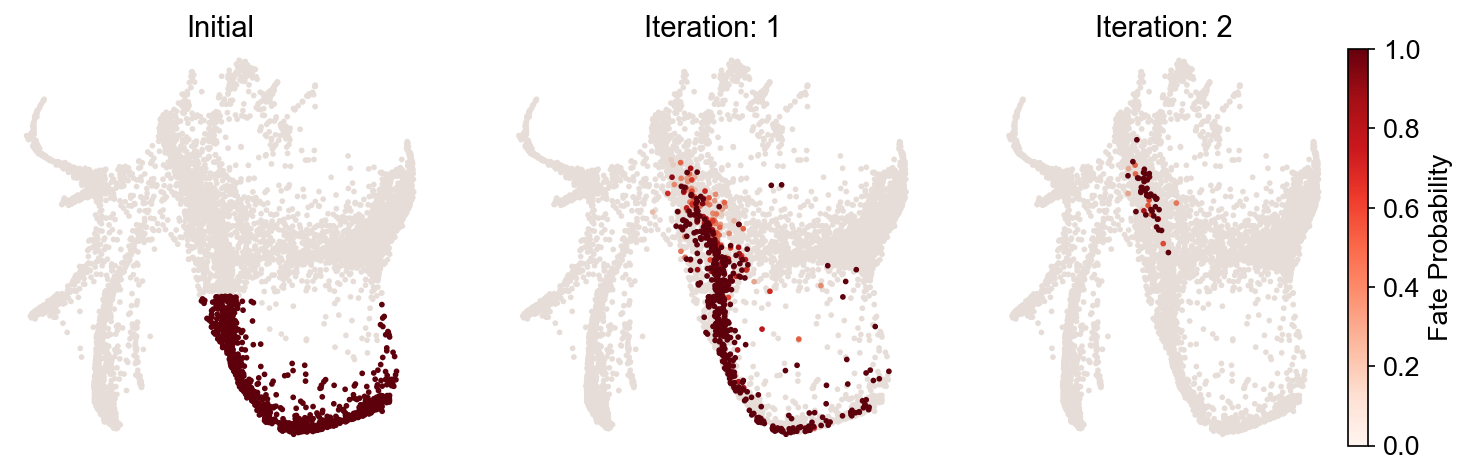

In [58]:
cs.pl.dynamic_trajectory_via_iterative_mapping(adata_5,
        selected_fate='Neutrophil',plot_separately=True,used_Tmap='intraclone_transition_map')

The trajectory can be used for visualizing gene expression dynamics using `cs.pl.gene_expression_dynamics`, as shown above:

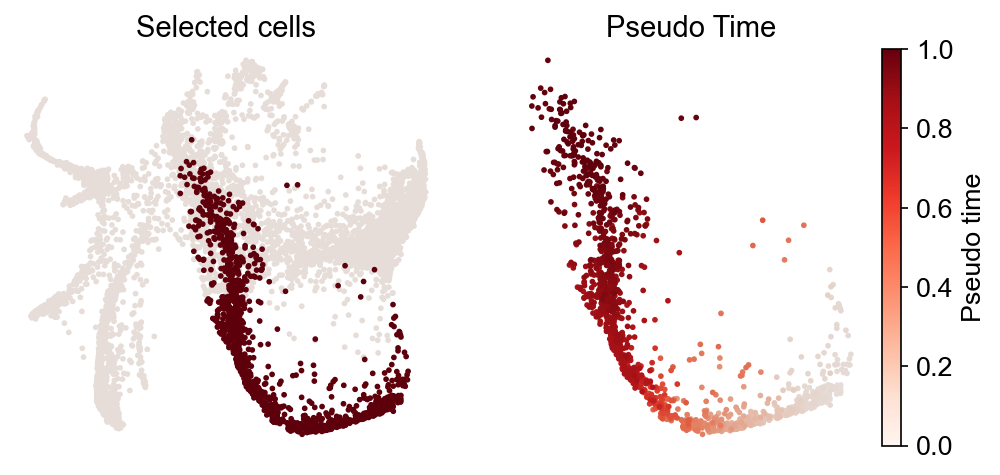

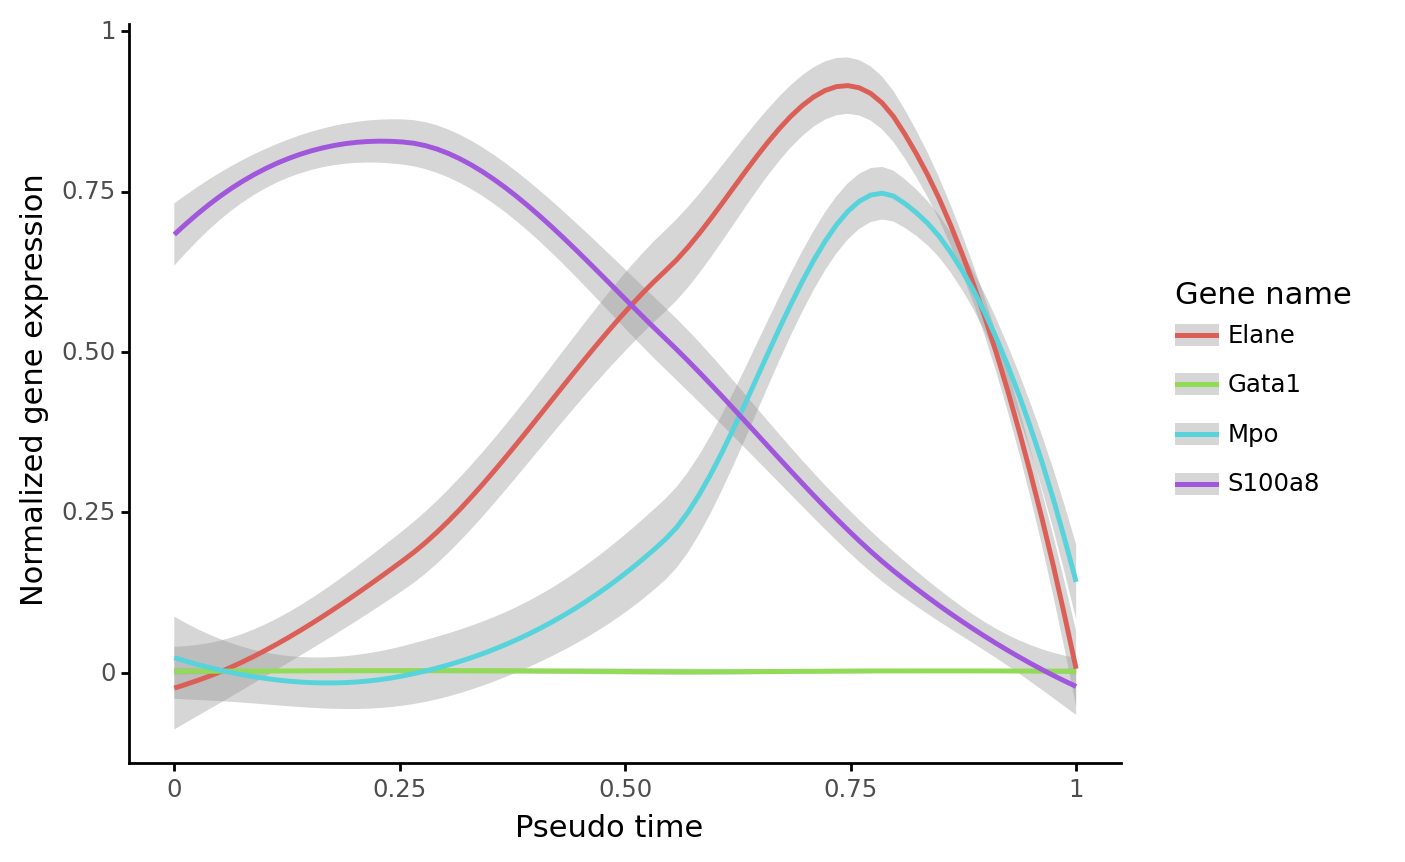

In [59]:
gene_name_list=['Gata1','Mpo', 'Elane', 'S100a8']
selected_fate='Neutrophil'
cs.pl.gene_expression_dynamics(adata_5,selected_fate,gene_name_list, traj_threshold=0.1,  
      invert_PseudoTime=True)